# fitting annihilation msr timeseries to the affine oscillatory particle model
Tim Tyree<br>
7.5.2022

In [4]:
from IPython.display import clear_output
clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [5]:
# from scipy.optimize import minimize
from scipy.optimize import dual_annealing

In [6]:
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [7]:
#copy to lib.model
def comp_square_error_msr_aff_osc(x,*args):
    """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.

Example Usage:
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr_aff_osc(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{rmse=}")
    """
    a0,a1,period,phase=x
    t_values,msr_values,D=args
    omega=2*np.pi/period*1e3 #Hz bc period is in ms
    msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
    square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
    return square_error_msr

def anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=1000,
                   seed=42,
                   no_local_search=True,
                   **kwargs):
    """returns fit of MSR(t') to the affine oscillatory particle model.
    if no_local_search=True, simulated annealing is used.
    if no_local_search=False, dual annealing is used.
    kwargs are passed to scipy.optimize.dual_annealing
    bounds gives the upper/lower bounds to parameter values a0 (cm^2/s), a1 (cm^2/s), period (ms), and phase (radians), respectively.

    Example Usage:
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=1000,seed=42, no_local_search=True)#,**kwargs)
    """
    # input: t_values, msr_values, D, Gamma
    # output: a0,a1,period,phase,rmse,alinear
    args=t_values,msr_values,D
    # np.random.seed(42)   # seed to allow replication.
    res = dual_annealing(
        comp_square_error_msr_aff_osc,
        bounds=bounds,
        args=args,
        maxiter=maxiter,
        seed=seed,
        no_local_search=no_local_search,**kwargs)
    return res

def comp_alinear(a0,a1,period,Gamma,phase):
    """computes the effective attraction coefficient of the linear particle model.
    a0,a1 are in units of alinear. 
    period is in units of the mean minimum lifetime, Gamma. 
    phase is in units of radians.
    
    Example Usage:
alinear = comp_alinear(a0,a1,period,Gamma,phase)
    """
    omega = 2*np.pi/period
    z = Gamma*omega
    alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
    return alinear

In [8]:
def comp_mean_bootstrap_uncertainty(x,num_samples=1000):
    """
    Example Usage:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f"mean: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")
    """
    meanx = np.mean(x)
    Delta_meanx,p_normal=bootstrap_95CI_Delta_mean(x,num_samples=num_samples)
    num_obs=x.shape[0]
    return meanx,Delta_meanx,num_obs,p_normal

# bootstrap msr from range timeseries data

In [9]:
# #load spiral tip range time series from cache
# #######################
# # Luo-Rudy
# #######################
# #WJ's data for LR model (200x200)
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
# range_data_dir=f'{nb_dir}/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
# # # #my data for LR model (200x200) diffCoeff=0.001
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'
# # #my data for LR model (200x200) diffCoeff=0.0005
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_range_timeseries.pkl'

# #######################
# # Fenton-Karma
# #######################
# # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_range_timeseries.pkl'
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_range_timeseries.pkl'
# # # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_range_timeseries.pkl'
# # # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilation_range_timeseries.pkl'

# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
# # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_annihilation_range_timeseries.pkl'

# # #150x150
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_annihilation_range_timeseries.pkl'
# # #200x200
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
# # #250x250
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_range_timeseries.pkl'


# # #################
# # # creations
# # ################
# # # #FK
# # # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_annihilation_range_timeseries.pkl'
# # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl'
# # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl'
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_range_timeseries.pkl'
# # # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_creation_range_timeseries.pkl'

# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_005_creation_range_timeseries.pkl'
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_creation_range_timeseries.pkl'




# # #LR 200x200
# # range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_creation_range_timeseries.pkl'

In [10]:
#####################
# Fenton-Karma
#####################
range_data_dir_lst=[
    #'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_annihilation_range_timeseries.pkl',
    '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl',
    #'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_range_timeseries.pkl',
]

# #####################
# # Luo-Rudy
# #####################
#runtime ~13 minutes
# range_data_dir_lst=[
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/250x250/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/300x300/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/350x350/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/400x400/tippos_per_c_001_annihilation_range_timeseries.pkl',
#     #'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/500x500/tippos_per_001_annihilation_range_timeseries.pkl',
#     #^this one is too big to track in a reasonable amount of time...     
# ]
for fn in range_data_dir_lst:
    print(f"{fn}")
    assert os.path.exists(fn)
print(f"^those exist")

/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl
^those exist


In [11]:
1

1

In [12]:
# max_tdeath=100. #ms #LR
max_tdeath=300. #ms FK
printing=True
D=0
use_sim_anneal=True
repeat_w_10X=True
for range_data_dir in range_data_dir_lst:
    print(f"\n{range_data_dir=}")
    data_lst=load_from_pickle(range_data_dir)
    num_termination_events = len(data_lst)
    print(f"loaded range timeseries from {len(data_lst)} termination events")

    df=pd.concat(data_lst)
    del data_lst
    print(f"{df.shape=}")
    # compute mean minimum lifetime
    minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
    meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
    printing=True
    if printing:
        print(f" - o - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
    Gamma=float(meanx)
    meanrange_values = df.groupby(by=['trial_num','annihilation_index'])['R'].mean().values
    meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
    printing=True
    if printing:
        print(f"averages for spiral tip pairs:")
        print(f" - x - particle average first (not this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
    # meanrange_values = df['R'].values
    # meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
    # if printing:
    #     print(f" - o - all positions together (use this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
    # meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meanrange_values**2)
    # if printing:
    #     print(f" - o - all positions together (use this one!): root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} ms (N={num_obsSR}, p_normal: {p_normalSR:.4f}) from {num_termination_events} termination events")

    # Compute MSR(t') by averaging range timeseries
    x_values_in=df['tdeath'].values
    y_values_in=df['R'].values**2
    print(f"tdeath ranges from {np.min(x_values_in)} to {np.max(x_values_in)} ms")
    print(f"R^2 ranges from {np.min(y_values_in)} to {np.max(y_values_in)} cm^2")

    assert not np.isnan(x_values_in).any() 
    assert not np.isnan(y_values_in).any()

    #compute bootstrap 
    printing=True
    if printing:
        print(f"boostrapping mean (estimated run time ~30 seconds)...")
    # bins=np.arange(0,450,1)
    # bins=np.arange(0,1800,5)
    bins=np.arange(0,2800,5)
    df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                                   y_values_in,
                                   xlabel='tdeath_avg',
                                   ylabel='MSR',
                                   bins=bins,
                                   min_numobs=10,
                                   num_bootstrap_samples=1000,
                                   npartitions=10,
                                   use_test=False)


    x_values=df_bootstrap['tdeath_avg'].values
    y_values=df_bootstrap['MSR'].values
    yerr_values=df_bootstrap['Delta_MSR'].values
    x_values.shape,y_values.shape,yerr_values.shape

    #save msr as .csv
    msr_dir_bootstrap=range_data_dir.replace('_range_timeseries.pkl','_msr.csv')
    df_bootstrap.to_csv(msr_dir_bootstrap,index=False)
    print(f"{msr_dir_bootstrap=}")

    # optionally fit alinear with simulated annealing
    # select msr from the full models for fitting
    boo=x_values<max_tdeath
    t_values=x_values[boo].copy()*1e-3
    msr_values=y_values[boo].copy() 
    #msr_values-= np.min(msr_values)
    print(f"{max_tdeath=} ms")
    print(f"src: {msr_dir_bootstrap=}")
    if use_sim_anneal:
        maxiter=10000
        print(f"num. epochs: {maxiter}")
        res = anneal_msr_fit(t_values,msr_values,D,
                           bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                           maxiter=maxiter,seed=42, no_local_search=True)#,**kwargs)
        rmse= np.sqrt(res.fun/t_values.shape[0])
        a0,a1,period,phase=res.x
        #print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

        alinear = comp_alinear(a0,a1,period,Gamma,phase)
        omega = 2*np.pi/period
        z = Gamma*omega
        print(f"\tsimulated annealing fit: {a0=:.9f}, {a1=:.9f}, {z=:.9f}, {phase=:.9f} --> {alinear=:.9f} cm^2/s")
        print(f">>> {alinear=} \n")    
        if repeat_w_10X:
            #optionally repeat at 10X number of epochs
            maxiter=100000
            print(f"num. epochs: {maxiter}")
            res = anneal_msr_fit(t_values,msr_values,D,
                               bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                               maxiter=maxiter,seed=42+1, no_local_search=True)#,**kwargs)
            rmse= np.sqrt(res.fun/t_values.shape[0])
            a0,a1,period,phase=res.x
            print(f"simulated annealing fit: {a0=:.9f}, {a1=:.9f}, {period=:.9f}, {phase=:.9f} --> {rmse=:.9f} cm^2")

            alinear = comp_alinear(a0,a1,period,Gamma,phase)
            omega = 2*np.pi/period
            z = Gamma*omega
            print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")
            print(f">>> {alinear=} \n")
            print(f"*************** end data set ********************")


range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
loaded range timeseries from 80 termination events
df.shape=(3846532, 9)
 - o - mean lifetime: 105.3196 +/- 1.6068 ms (N=36179, p_normal: 0.6404) from 80 termination events
averages for spiral tip pairs:
 - x - particle average first (not this one!): mean range: 0.5263 +/- 0.0035 ms (N=36179, p_normal: 0.0055) from 80 termination events
tdeath ranges from 0.0 to 2710.0 ms
R^2 ranges from 6.249999999999291e-06 to 12.387906250000002 cm^2
boostrapping mean (estimated run time ~30 seconds)...
msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
max_tdeath=300.0 ms
src: msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
num. epochs: 10000
	simulated annealin

## see which method of averaging $R_i(t')$ results in alinear values similar to expected

In [13]:
###########################
# mean min lifetime: Gamma
###########################
tscale=1e-3 #s per ms
lifetime_fk= 105.3 # (1.6) ms
lifetime_lr= 33.37 # (73) ms
Gamma_fk = lifetime_fk*tscale
Gamma_lr = lifetime_lr*tscale

In [14]:
#alinear from simulated annealing
alinear_expected_fk = 1.9252  #cm^2/s
alinear_expected_lr = 11.2437 #cm^2/s
print(f"{alinear_expected_fk=:.4f} cm^2/s")
print(f"{alinear_expected_lr=:.4f} cm^2/s")

alinear_expected_fk=1.9252 cm^2/s
alinear_expected_lr=11.2437 cm^2/s


In [88]:
#load annihilation range timeseries
range_data_dir_fk='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_range_timeseries.pkl'
range_data_dir=range_data_dir_fk
data_lst=load_from_pickle(range_data_dir)
num_termination_events = len(data_lst)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df_fk=pd.concat(data_lst)
del data_lst
print(f"{df_fk.shape=}")

range_data_dir_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_range_timeseries.pkl'
range_data_dir=range_data_dir_lr
data_lst=load_from_pickle(range_data_dir)
num_termination_events = len(data_lst)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df_lr=pd.concat(data_lst)
del data_lst
print(f"{df_lr.shape=}")
df_fk['Rsq']=df_fk['R']**2
df_lr['Rsq']=df_lr['R']**2
df_fk['model']='Fenton-Karma'
df_lr['model']='Luo-Rudy'
df_concat = pd.concat([df_fk,df_lr])
df_concat.reset_index(inplace=True)

loaded range timeseries from 80 termination events
df_fk.shape=(3846532, 9)
loaded range timeseries from 595 termination events
df_lr.shape=(524869, 9)


In [89]:
random_state=42
num_sample=1000
#use seaborn to scatter plot R vs. Rsq vs. tdeath 

<function seaborn.axisgrid.pairplot(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)>

In [10]:
# # fig,ax=plt.subplots()
# sig = sns.pairplot(df_concat.sample(num_sample,random_state=random_state), 
#                    vars=["R", "Rsq", 'tdeath'],
#                    diag_kind="kde",
#                    hue='model',plot_kws={'alpha':0.4})
# plt.title('before any averaging')
# plt.show()

In [87]:
# sig = sns.pairplot(df_lr, vars=["R", "Rsq", 'tdeath'],diag_kind="kde")
# plt.show()

In [ ]:
#TODO: search for single particle alinear estimator

In [ ]:
#TODO: plot single particle alinear estimator


In [64]:
# df=df_fk.copy()
# alinear_expected = float(alinear_expected_fk)
df=df_fk.copy()
# df.sort_values(by=['trial_num','annihilation_index','tdeath'])
# for (trial_num,annihilation_index),g in df.groupby(by=['trial_num','annihilation_index']):
df.sort_values(by=['model','trial_num','annihilation_index','tdeath'])
for (model_name,trial_num,annihilation_index),g in df.groupby(by=['model','trial_num','annihilation_index']):
    g[["R", "Rsq", 'tdeath']]

(0.0, 6.0, 0.0, 0.6)

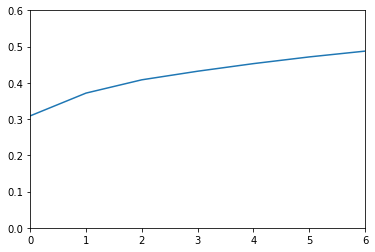

In [67]:
trial_num,annihilation_index
t_values = g['tdeath'].values.copy()
R_values = g['R'].values.copy()
#DONE: compute first order tshift bounded between 0 and 1
#NOTE: first test case had tshift>1.  this lead to 6 months of confusion in the past... make no adjustment to R or time!
# tshift=0.
# # if R_values[0]>0:
# #     #tshift=(t_values[1]-t_values[0])*(R_values[1]-R_values[0])/R_values[0]
# #     #tshift=(t_values[1]-t_values[0])*R_values[0]/(R_values[1]-R_values[0])
# #     tshift=(t_values[1]-t_values[0])*np.sqrt(R_values[0]/(R_values[1]-R_values[0]))
# #     t_values+=tshift

plt.plot(t_values,R_values)

#plot alinear for this trajectory
R_values

#comparably plot alinear_expected for this trajectory


plt.axis([0,6,0,.6])

In [ ]:
# compute mean minimum lifetime
minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f" - o - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
Gamma=float(meanx)
meanrange_values = df.groupby(by=['trial_num','annihilation_index'])['R'].mean().values
meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
printing=True
if printing:
    print(f"averages for spiral tip pairs:")
    print(f" - x - particle average first (not this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
# meanrange_values = df['R'].values
# meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
# if printing:
#     print(f" - o - all positions together (use this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")
# meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meanrange_values**2)
# if printing:
#     print(f" - o - all positions together (use this one!): root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} ms (N={num_obsSR}, p_normal: {p_normalSR:.4f}) from {num_termination_events} termination events")


## plot the final instance of ibid

Does this appear to intersect at zero?


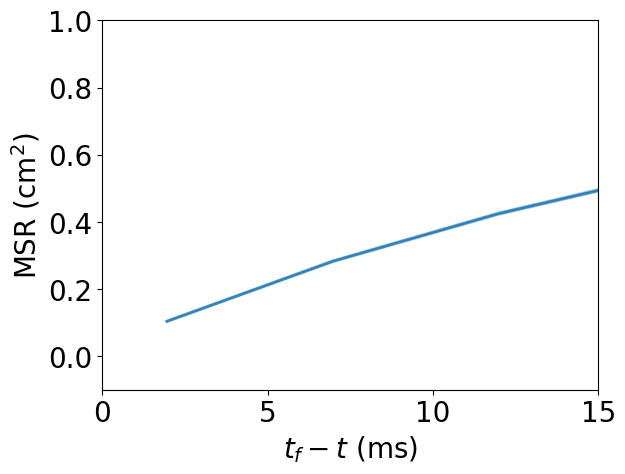

In [50]:
print(f"Does this appear to intersect at zero?")
c='C0'
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,15])
plt.ylim([-.1,1])
plt.show()

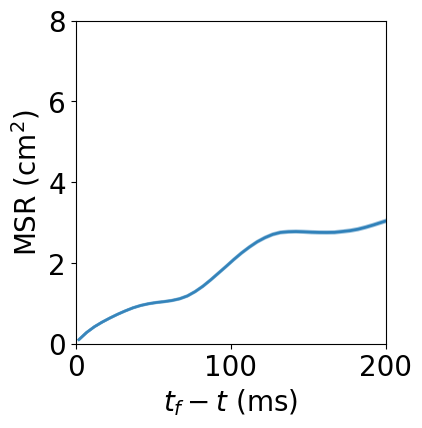

In [51]:
#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
ax.set_ylim([0,8])
plt.show()

NameError: name 'x_values' is not defined

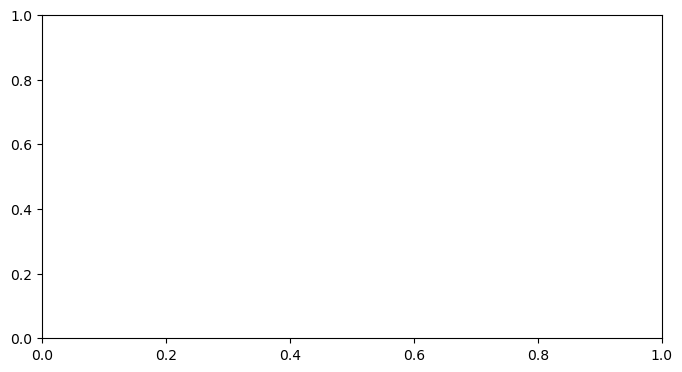

In [21]:
c='C0'
# c='C1'

#plot expected
fig,ax=plt.subplots(figsize=(8,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,2000])
ax.set_ylim([0,8])
plt.show()

In [263]:
bins=80
color='C1'
# color='C0'
# bins=np.logspace(-2,2,100)
plt.hist(minlifetime_values,bins=bins,density=True,log=True,color=color,alpha=0.7)
format_plot(ax=plt.gca(),xlabel=r'min$(\Gamma_1,\Gamma_2)$ (ms)',ylabel='PDF')
plt.xlim([0,2.5e3])
plt.show()plt.show()



In [264]:
# input_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv'
# input_folder=os.path.dirname(input_dir)
# fn_lst=[os.path.join(input_folder,x) for x in sorted(os.listdir(input_folder)) if x.find('_log.csv')!=-1]
# print(f"found {len(fn_lst)} files comparable to {fn_lst[0]}")


# MSR-Consistent Theory

$\text{MSR}_\text{Lin.}(t')=4\Big(2Dt'+a_0t'\Big)$

$\text{MSR}_\text{Aff.Osc.}(t')=4\Big(2Dt'+a_0t'+\frac{a_1}{\omega} \big(\sin(\omega t' + \phi_f)-\sin(\phi_f) \big)\Big)$

Our hypothesis is that the range between particles is consistent between the two particle models in the mean square.  In other words,
$$
\mathbb{E}_{\Gamma/2}\Big[\text{MSR}_\text{Lin.}\Big] \overset{!}{=} \mathbb{E}_{\Gamma/2}\Big[\text{MSR}_\text{Aff.Osc}\Big].
$$

Let $z=\omega(\Gamma/2)$, $D_\text{Aff.Osc.}=D_\text{Lin.}=D=$constant, and let $\phi_f=0$. Then, the aforementioned _ansatz_ simplifies to

$$
a_\text{Lin.}=a_0 + \frac{a_1}{1+z^2}.
$$


For general $\phi_f\in\mathbb{R}$, the aforementioned _ansatz_ simplifies to

$$
a_\text{Lin.}=a_0 + a_1\frac{\cos(\phi_f)-z\sin(\phi_f)}{1+z^2}.
$$

In [265]:
#WJ'S informal fit from fortran
#predicted values
a0=5.4958675607488825 #cm^2/s
a1=6.2229999145162314 #cm^2/s
period=179.51957944083097 #ms
# phase=1.1497012691466562
# phase=0
phase=-1.1497012691466562
Gamma = 20 #ms


omega = 2*np.pi/period
z = Gamma*omega
alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
print(f"{a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f}")

a0=5.4959, a1=6.2230, z=0.7000, phase=-1.1497 --> alinear=9.8712


# Fit MSR(t') to a pure diffusing particle model

In [ ]:
#heretim

In [1]:
# #DONT: recall my full model range data
# msr_dir_bootstrap_fk = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv"
# input_fn_range_timeseries_fk = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'

#recall my full model range data for LR
msr_dir_bootstrap_lr = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv"
input_fn_range_timeseries_lr = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'

In [2]:
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_creation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'

#recall WJ's full model range data for LR
msr_dir_bootstrap_fk = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
msr_dir_bootstrap_lr = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'


In [3]:
msr_dir_bootstrap = msr_dir_bootstrap_lr
df_bootstrap=pd.read_csv(msr_dir_bootstrap)


x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

NameError: name 'pd' is not defined

In [14]:
# select msr from the full models for fitting
min_tdeath=100. #ms  #LR
# # min_tdeath=300. #ms  #FK 
# min_tdeath=600. #ms  #FK 
max_tdeath=1500. #ms  #FK 
printing=True

boo=x_values>=min_tdeath
boo&=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy() 
# msr_values-= np.min(msr_values)
msr_values.shape

(74,)

In [15]:
dict_output = compute_95CI_ols(x=t_values,y=msr_values)
D = dict_output['m']/8
Delta_D = dict_output['Delta_m']/8
if printing:
    print(f"D = m/8 = {D:.4f} +/- {Delta_D} (using timepoints after {min_tdeath} ms)")
    print_dict(dict_output)

D = m/8 = 0.4158 +/- 0.1383129275716018 (using timepoints after 100.0 ms)
m=3.326383424216691
Delta_m=1.1065034205728144
b=2.628068787318341
Delta_b=0.33621752246125236
Rsquared=0.3253229378129055


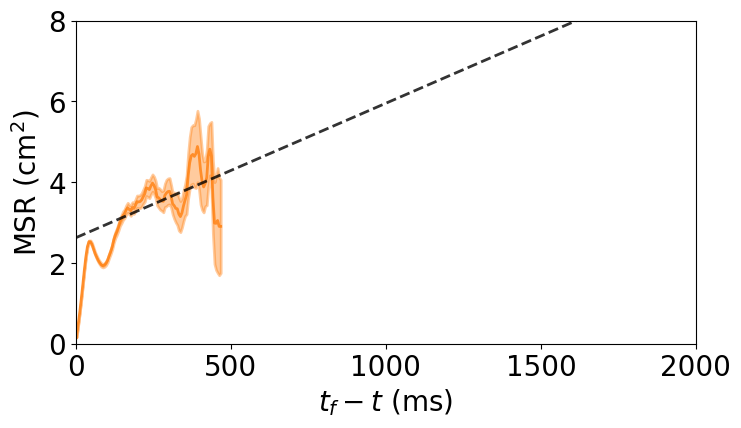

In [17]:
# c='C0'
c='C1'
xlim = [0,2000]
#plot expected
fig,ax=plt.subplots(figsize=(8,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)

#plot linear fit
xv = np.arange(xlim[0],xlim[1],1)
yv = 1e-3*dict_output['m']*xv + dict_output['b']
ax.plot(xv,yv,'k--',lw=2,alpha=0.8)

#format plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim(xlim)
ax.set_ylim([0,8])
plt.show()

# Fit MSR(t') to the affine oscillatory model

## load MSR(t') data

In [17]:
# # #######################
# # # Luo-Rudy
# # #######################
#WJ's data for LR model (200x200)
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'

# # # #my data for LR model (200x200) diffCoeff=0.001
# # # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# #my data for LR model (200x200) diffCoeff=0.0005
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'

# # #######################
# # # Fenton-Karma
# # #######################
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_msr.csv'
# # # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_msr.csv'
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_msr.csv'

In [22]:
# #######################
# # Luo-Rudy
# #######################
# # # #WJ's data for LR model (200x200) diffCoeff=0.001
# msr_dir_bootstrap = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv' # # #######################
# # msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/from_wjr/lr_200x200_diffcoeff_0.001/tippos_per_001_annihilation_msr.csv'
# # # # # #my data for LR model (200x200) diffCoeff=0.001
# # msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-suite-3-LR_ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# # # # # #my data for LR model (200x200) diffCoeff=0.0005
# # # msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-condition-suite-3-LR_param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'

# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_creation_msr.csv'
# # # #######################
# # # # Fenton-Karma
# # # #######################
# msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-fk-200x200_param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_msr.csv'
# # msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-fk-200x200_param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_msr.csv'

# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# # mean lifetime: 105.3196 +/- 1.5647 ms (N=36179, p_normal=0.4417)

# # #150x150
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_annihilation_msr.csv'
# # #200x200
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# #250x250
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_msr.csv'
# # tippos_per_001_annihilation_range_timeseries.pkl


In [11]:
msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/150x150/tippos_per_c_001_annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
print(f"{msr_dir_bootstrap=}")
assert os.path.exists(msr_dir_bootstrap)

msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_msr.csv'


In [12]:
df_bootstrap=pd.read_csv(msr_dir_bootstrap)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,1.923340,0.082530,0.003135,0.000193,0.274177,0.958130,864298
1,6.969682,0.187651,0.003087,0.000355,0.233743,0.835536,768662
2,11.977391,0.249455,0.003299,0.000523,0.443233,0.325924,720687
3,16.975718,0.298839,0.003340,0.000604,0.454680,0.319119,679920
4,21.972589,0.344948,0.003470,0.000747,0.962179,0.880686,636977


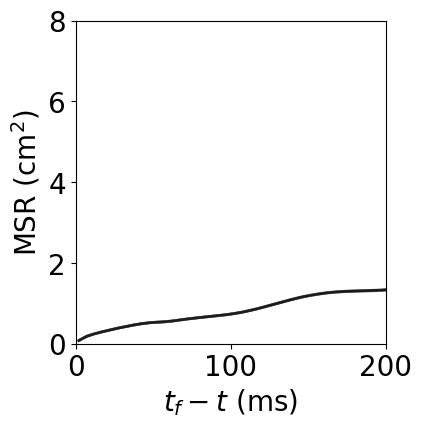

In [71]:
#plot expected
# c='C0'
c='C1'
c='k'
# figsize=(8,4.2)
figsize=(4,4.2)

x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

fig,ax=plt.subplots(figsize=figsize)
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
# ax.set_xlim([0,2000])
ax.set_ylim([0,8])
plt.show()

# recall the mean minimum lifetime

In [72]:
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_lr/200x200/tippos_per_001_annihilation_msr.csv'
trgt_str = 'msr.csv'
range_data_dir = msr_dir_bootstrap.replace(trgt_str,'range_timeseries.pkl')
print(f"{range_data_dir=}")
assert os.path.exists(range_data_dir)

range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_range_timeseries.pkl'


In [73]:
#heretim
data_lst=load_from_pickle(range_data_dir)
num_termination_events = len(data_lst)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df=pd.concat(data_lst)
del data_lst
print(f"num. obs: {df.shape[0]}")
minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f" - mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
Gamma = meanx

loaded range timeseries from 29 termination events
num. obs: 17439817
 - mean lifetime: 91.2055 +/- 0.6642 ms (N=189141, p_normal: 0.1699) from 29 termination events


In [74]:
# # # Gamma = 100. # ~ 197/2 #ms #for predicting alinear only
# Gamma = 93. #ms for FK 200x200, diffCoeff=0.0005
# # Gamma = 87. #ms for FK 200x200, diffCoeff=0.001
# # Gamma = 105.3196 #+/- 1.5647 ms (N=36179, p_normal=0.4417) diffCoeff=0.0005? 200x200
# Gamma = 105.5460 #+/- 6.1482 ms (N=3220, p_normal=0.2679)  diffCoeff=0.0005? 150x150
# # meanx,Delta_meanx,num_obsx,p_normalx=comp_mean_bootstrap_uncertainty(minlifetime_values)
# # Gamma=float(meanx)
# if printing:
# #     print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f})")
#     print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obsx}, p_normal: {p_normalx:.4f}) from {num_termination_events} termination events")
#     print(f"setting {Gamma=:.4f}, {D=:.0f}...")
# Gamma = 200.#ms
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/200x200/tippos_per_c_001_annihilation_msr.csv'
# mean lifetime: 105.3196 +/- 1.5647 ms (N=36179, p_normal=0.4417)

## fit the full msr to the affine oscillatory msr using simulated annealing

In [75]:
# select msr from the full models for fitting
# max_tdeath=100. #ms #LR
max_tdeath=300. #ms FK
printing=True
#INPUT: FK MODEL
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy() 
msr_values-= np.min(msr_values)
D=0
# D=0.365 #cm^2/s, as observed
# D=0.25 #cm^2/s, as observed more recently
# D=0. #cm^2/s
# D=0.1 #cm^2/s
# D=0.2 #cm^2/s

# # #INPUT: LR MODEL
# max_tdeath=100. #ms
# boo=x_values<max_tdeath
# t_values=x_values[boo].copy()*1e-3
# msr_values=y_values[boo].copy()
# msr_values-= np.min(msr_values)
# D=0.58 #cm^2/s, as observed
# Gamma = 33.4 # 20. # ~ 40/2 #ms #for predicting alinear only
print(f"{max_tdeath=} ms")
print(f"src: {msr_dir_bootstrap=}")
maxiter=10000
print(f"num. epochs: {maxiter}")
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=maxiter,seed=42, no_local_search=True)#,**kwargs)
rmse= np.sqrt(res.fun/t_values.shape[0])
a0,a1,period,phase=res.x
print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")

max_tdeath=300.0 ms
src: msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/positions_fk/250x250/tippos_per_001_annihilation_msr.csv'
num. epochs: 10000
simulated annealing fit: a0=1.6811, a1=1.3946, period=119.0635, phase=-0.3620 --> rmse=0.0399 cm^2
	attraction coefficient: a0=1.6811, a1=1.3946, z=4.8131, phase=-0.3620 --> alinear=1.8334 cm^2/s


In [76]:
maxiter=100000
print(f"num. epochs: {maxiter}")
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=maxiter,seed=42+1, no_local_search=True)#,**kwargs)
rmse= np.sqrt(res.fun/t_values.shape[0])
a0,a1,period,phase=res.x
print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")

num. epochs: 100000
simulated annealing fit: a0=1.6806, a1=1.3954, period=119.0325, phase=-0.3650 --> rmse=0.0399 cm^2
	attraction coefficient: a0=1.6806, a1=1.3954, z=4.8143, phase=-0.3650 --> alinear=1.8337 cm^2/s


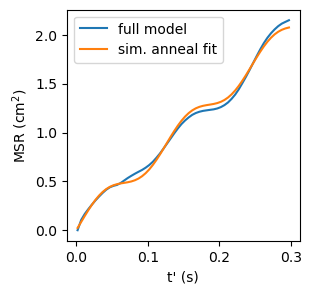

In [77]:
#visualize the fit zoomed
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3

figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='sim. anneal fit')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

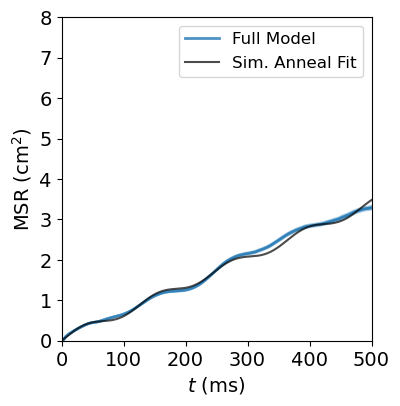

In [78]:
xlabel=r'$t_f-t$ (ms)'
xlabel=r'$t$ (ms)'

#plot expected
c='C0'
# c='C1'
# figsize=(8,4.2)
figsize=(4,4.2)
fontsize=14

x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
y_values-=np.min(y_values)
yerr_values=df_bootstrap['Delta_MSR'].values

t_values=x_values*1e-3
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))



fig,ax=plt.subplots(figsize=figsize)
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c, label='Full Model')
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)

ax.plot(t_values*1e3,msr_values_affoscillatory,label='Sim. Anneal Fit',c='k',alpha=0.7)

format_plot(ax=ax,xlabel=xlabel,ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
ax.set_xlim([0,500])
# ax.set_xlim([0,2000])
ax.set_ylim([0,8])
plt.legend(fontsize=fontsize-2)

plt.show()

In [ ]:
meanrange_values = df['R'].values
meanR,Delta_meanR,num_obsR,p_normalR=comp_mean_bootstrap_uncertainty(meanrange_values)
if printing:
    print(f" - o - all positions together (use this one!): mean range: {meanR:.4f} +/- {Delta_meanR:.4f} ms (N={num_obsR}, p_normal: {p_normalR:.4f}) from {num_termination_events} termination events")

print(f"{meanR**2/Gamma/32=}")
    
meanSR,Delta_meanSR,num_obsSR,p_normalSR=comp_mean_bootstrap_uncertainty(meanrange_values**2)
if printing:
    print(f" - o - all positions together (use this one!): root mean squared range: {np.sqrt(meanSR):.4f} +/- {0.5*np.sqrt(Delta_meanSR)/np.sqrt(meanSR):.4f} ms (N={num_obsSR}, p_normal: {p_normalSR:.4f}) from {num_termination_events} termination events")

print(f"{meanSR/Gamma/32=}")

    

# (supplementary) fit MSR(t') using fancy, complicated methods

In [590]:
from scipy.optimize import minimize
def comp_square_error_msr_period_fixed(x,*args):
    """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.

Example Usage:
x0=a0,a1,phase
args=t_values,msr_values,D,period
square_error=comp_square_error_msr_aff_osc(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{rmse=}")
    """
    a0,a1,phase=x
    t_values,msr_values,D,period=args
    omega=2*np.pi/period*1e3 #Hz bc period is in ms
    msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
    square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
    return square_error_msr

m=14.413057752177012
b=1.0696028305996794
Rsquared=0.38314383286833603


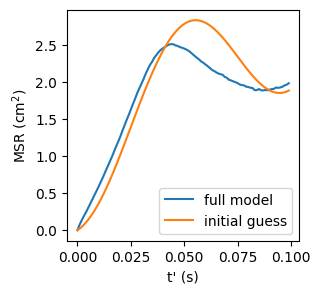

rmse=0.2967137861796891
baseline loss: rmse=0.2967 cm^2 (from a0=3.6033, a1=14.4131, period=100.0000, phase=-1.5708)
method='Nelder-Mead': a0_=4.3331, a1_=12.6700, period_=104.4021, phase_=-1.0350, rmse=0.06022575035499659
method='Powell': a0_=4.3330, a1_=12.6699, period_=104.4021, phase_=-1.0350, rmse=0.06022574586310302
method='CG': a0_=4.3329, a1_=12.6701, period_=104.4021, phase_=-1.0350, rmse=0.06022575065235818
method='BFGS': a0_=4.3331, a1_=12.6698, period_=104.4021, phase_=-1.0349, rmse=0.06022574402984597
method='L-BFGS-B': a0_=4.3339, a1_=12.6684, period_=104.4021, phase_=-1.0348, rmse=0.060225857449732925
method='TNC': a0_=4.2220, a1_=12.6540, period_=104.4021, phase_=-1.0781, rmse=0.06315296102878984
method='COBYLA': a0_=4.3152, a1_=12.7670, period_=104.4021, phase_=-1.0336, rmse=0.06051079214409579
method='SLSQP': a0_=4.3299, a1_=12.6710, period_=104.4021, phase_=-1.0361, rmse=0.06022781687964303
method='trust-constr': a0_=4.3332, a1_=12.6699, period_=104.4021, phase_=-1.0

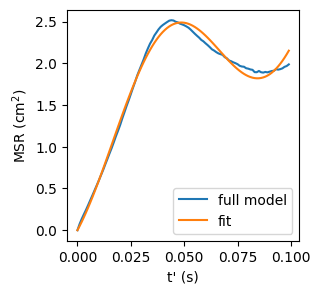

In [589]:
dict_output = comp_ols_simple(t_values,msr_values)
print_dict(dict_output)
#reasonable guess for a0
a0 = dict_output['m']/4 #- 2*D
a1 = float(a0)*4
#reasonable guess for phi_f
phase=-np.pi/2
period=100 #ms

#visualize the fitty
figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='initial guess')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

x0=a0,a1,phase
args=t_values,msr_values,D,period
square_error=comp_square_error_msr_period_fixed(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"baseline loss: {rmse=:.4f} cm^2 (from {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f})")

#DONDE: vary a0, a1
# method_lst=['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']
#jacobian needed # 'dogleg', 'Newton-CG', 'trust-ncg', 'trust-exact','trust-krylov' #jacobian needed
method_lst=['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']
bounds = ((0, 100), (0, 100), (-3.2,3.2))
np.random.seed(42)   # seed to allow replication.
for method in method_lst:
    res = minimize(comp_square_error_msr_period_fixed, x0, args, method=method, bounds=bounds,tol=1e-3)
    # res.x is in the basis of a0,a1  #,period,phase
    a0_=res.x[0];a1_=res.x[1];phase_=res.x[2]
    square_error=comp_square_error_msr_period_fixed(res.x,*args)
    rmse=np.sqrt(square_error/t_values.shape[0])
    print(f"{method=}: {a0_=:.4f}, {a1_=:.4f}, {period_=:.4f}, {phase_=:.4f}, {rmse=}")

#visualize the fitty
a0_,a1_,phase_=res.x
period_=period
figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period_*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0_)*t_values+(a1_/omega)*(np.sin(omega*t_values+phase_)-np.sin(phase_)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='fit')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

# (supplementary) naive guess at fit

In [ ]:
#naive guess

#INPUT: FK MODEL
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy() 
msr_values-= np.min(msr_values)
D=0.365 #cm^2/s, as observed
Gamma = 100. # ~ 197/2 #ms #for predicting alinear only

#INPUT: LR MODEL
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy()
msr_values-= np.min(msr_values)
D=0.58 #cm^2/s, as observed
Gamma = 20. # ~ 40/2 #ms #for predicting alinear only

dict_output = comp_ols_simple(t_values,msr_values)
# print_dict(dict_output)
#reasonable guess for a0
a0 = dict_output['m']/4 #- 2*D
a1 = float(a0)*4
#reasonable guess for phi_f
phase=-np.pi/2
period=80 #ms

dict_output = comp_ols_simple(t_values,msr_values)
# print_dict(dict_output)
#reasonable initial guess for a0
a0 = dict_output['m']/4 #- 2*D
a1 = float(a0)*4
#reasonable guess for phi_f
phase=-np.pi/2
period=90 #ms

#simulated annealing of all variables
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"baseline loss: {rmse=:.4f} cm^2 (from {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f})")

#visualize the fitty
figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='initial guess')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()